# Entrenamiento modelo vivit para LSC

## Importar las dependencias necesarias

In [1]:
from pathlib import Path

import torch
from transformers import Trainer, TrainingArguments, DefaultDataCollator, EarlyStoppingCallback
from datasets import DatasetDict, load_from_disk 

import config
# from train.optuna import objective
from data.load import load_video_metadata, create_label_mappings
from data.datasets import build_huggingface_dataset
from data.preprocesing import create_map_function
from model.load import load_model, load_image_processor
from training.metrics import compute_metrics

## Verificar si se cuenta con tarjeta grafica compatible con CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



## PASO 1: Cargar Rutas y crear Metadata

In [3]:
# Definir la ruta base
base_dataset_path = Path("../dataset")
# Cargar datos de cada split
# --- PASO 1: Cargar Metadatos ---
base_dataset_path = Path("../dataset")
video_metadata = load_video_metadata(base_dataset_path)

--- Cargando Metadatos desde: ..\dataset ---
  Procesando: ..\dataset\train...
    -> 150 videos cargados.
  Procesando: ..\dataset\eval...
    -> 30 videos cargados.
  Procesando: ..\dataset\test...
    -> 39 videos cargados.
Metadatos cargados para 219 videos.


## PASO 2: Crear Mapeos y construir DatasetDict

In [4]:
label2id, id2label = create_label_mappings(video_metadata)
raw_dataset = build_huggingface_dataset(video_metadata, label2id)

print("\n--- Dataset Crudo Cargado ---")
print(raw_dataset)


--- Creando Mapeos de Etiquetas ---
Se crearon mapeos para 10 clases.
¡DatasetDict construido!

--- Dataset Crudo Cargado ---
DatasetDict({
    train: Dataset({
        features: ['video_path', 'label'],
        num_rows: 150
    })
    validation: Dataset({
        features: ['video_path', 'label'],
        num_rows: 30
    })
    test: Dataset({
        features: ['video_path', 'label'],
        num_rows: 39
    })
})


## PASO 3: Cargar Modelo e Image Processor

In [5]:
model = load_model(
    model_ckpt=config.MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    device=device,
    freeze_base=True,
    unfreeze_last_n=3
)
image_processor = load_image_processor(
    model_ckpt=config.PROCCESSOR
)

Unique classes: ['ABUELO', 'ADIOS', 'BIEN', 'COMER', 'COMO_ESTAS', 'HAMBRE', 'HOLA', 'NINA', 'NINO', 'POR_FAVOR'].


Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freezing base layers except the last 3 encoder layers...
Model moved to device: cuda


## PASO 4: Aplicando Preprocesamiento (PyAV + Aug Avanzada)

In [6]:
height = width = image_processor.size["shortest_edge"]
resize_to = (height, width)
num_frames_to_sample = model.config.num_frames

processed_dataset_path = Path("./processed_sign_language_dataset")

if processed_dataset_path.exists():
    print(f"Cargando 'processed_dataset' desde el disco: {processed_dataset_path}")
    processed_dataset = load_from_disk(str(processed_dataset_path))
    # Es importante volver a establecer el formato después de cargar desde disco
    processed_dataset.set_format("torch")
    print("'processed_dataset' cargado.")
else:
    train_map_fn = create_map_function(image_processor, num_frames_to_sample, resize_to, is_train=True)
    val_test_map_fn = create_map_function(image_processor, num_frames_to_sample, resize_to, is_train=False)

    # Aplicar .map() - ESTO ES LO QUE CREA EL CONTENIDO DEL NUEVO DATASET
    processed_dataset = DatasetDict({
        'train': raw_dataset['train'].map(train_map_fn, remove_columns=['video_path'], batched=False), # Quitamos path y label_str
        'validation': raw_dataset['validation'].map(val_test_map_fn, remove_columns=['video_path'], batched=False),
        'test': raw_dataset['test'].map(val_test_map_fn, remove_columns=['video_path'], batched=False),
    })
    
    processed_dataset = processed_dataset.filter(
        lambda x: x['pixel_values'] is not None
    )
    print("Filtrado completado.")
    processed_dataset.save_to_disk(str(processed_dataset_path))
    # Establecer formato PyTorch
    processed_dataset.set_format("torch")

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39 [00:00<?, ? examples/s]

Filtrado completado.


Saving the dataset (0/6 shards):   0%|          | 0/150 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/30 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/39 [00:00<?, ? examples/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8431373..0.7490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7490196..0.5294118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9215686..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7490196..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7333333..0.30980396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7960784..0.26274514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0..1.0].


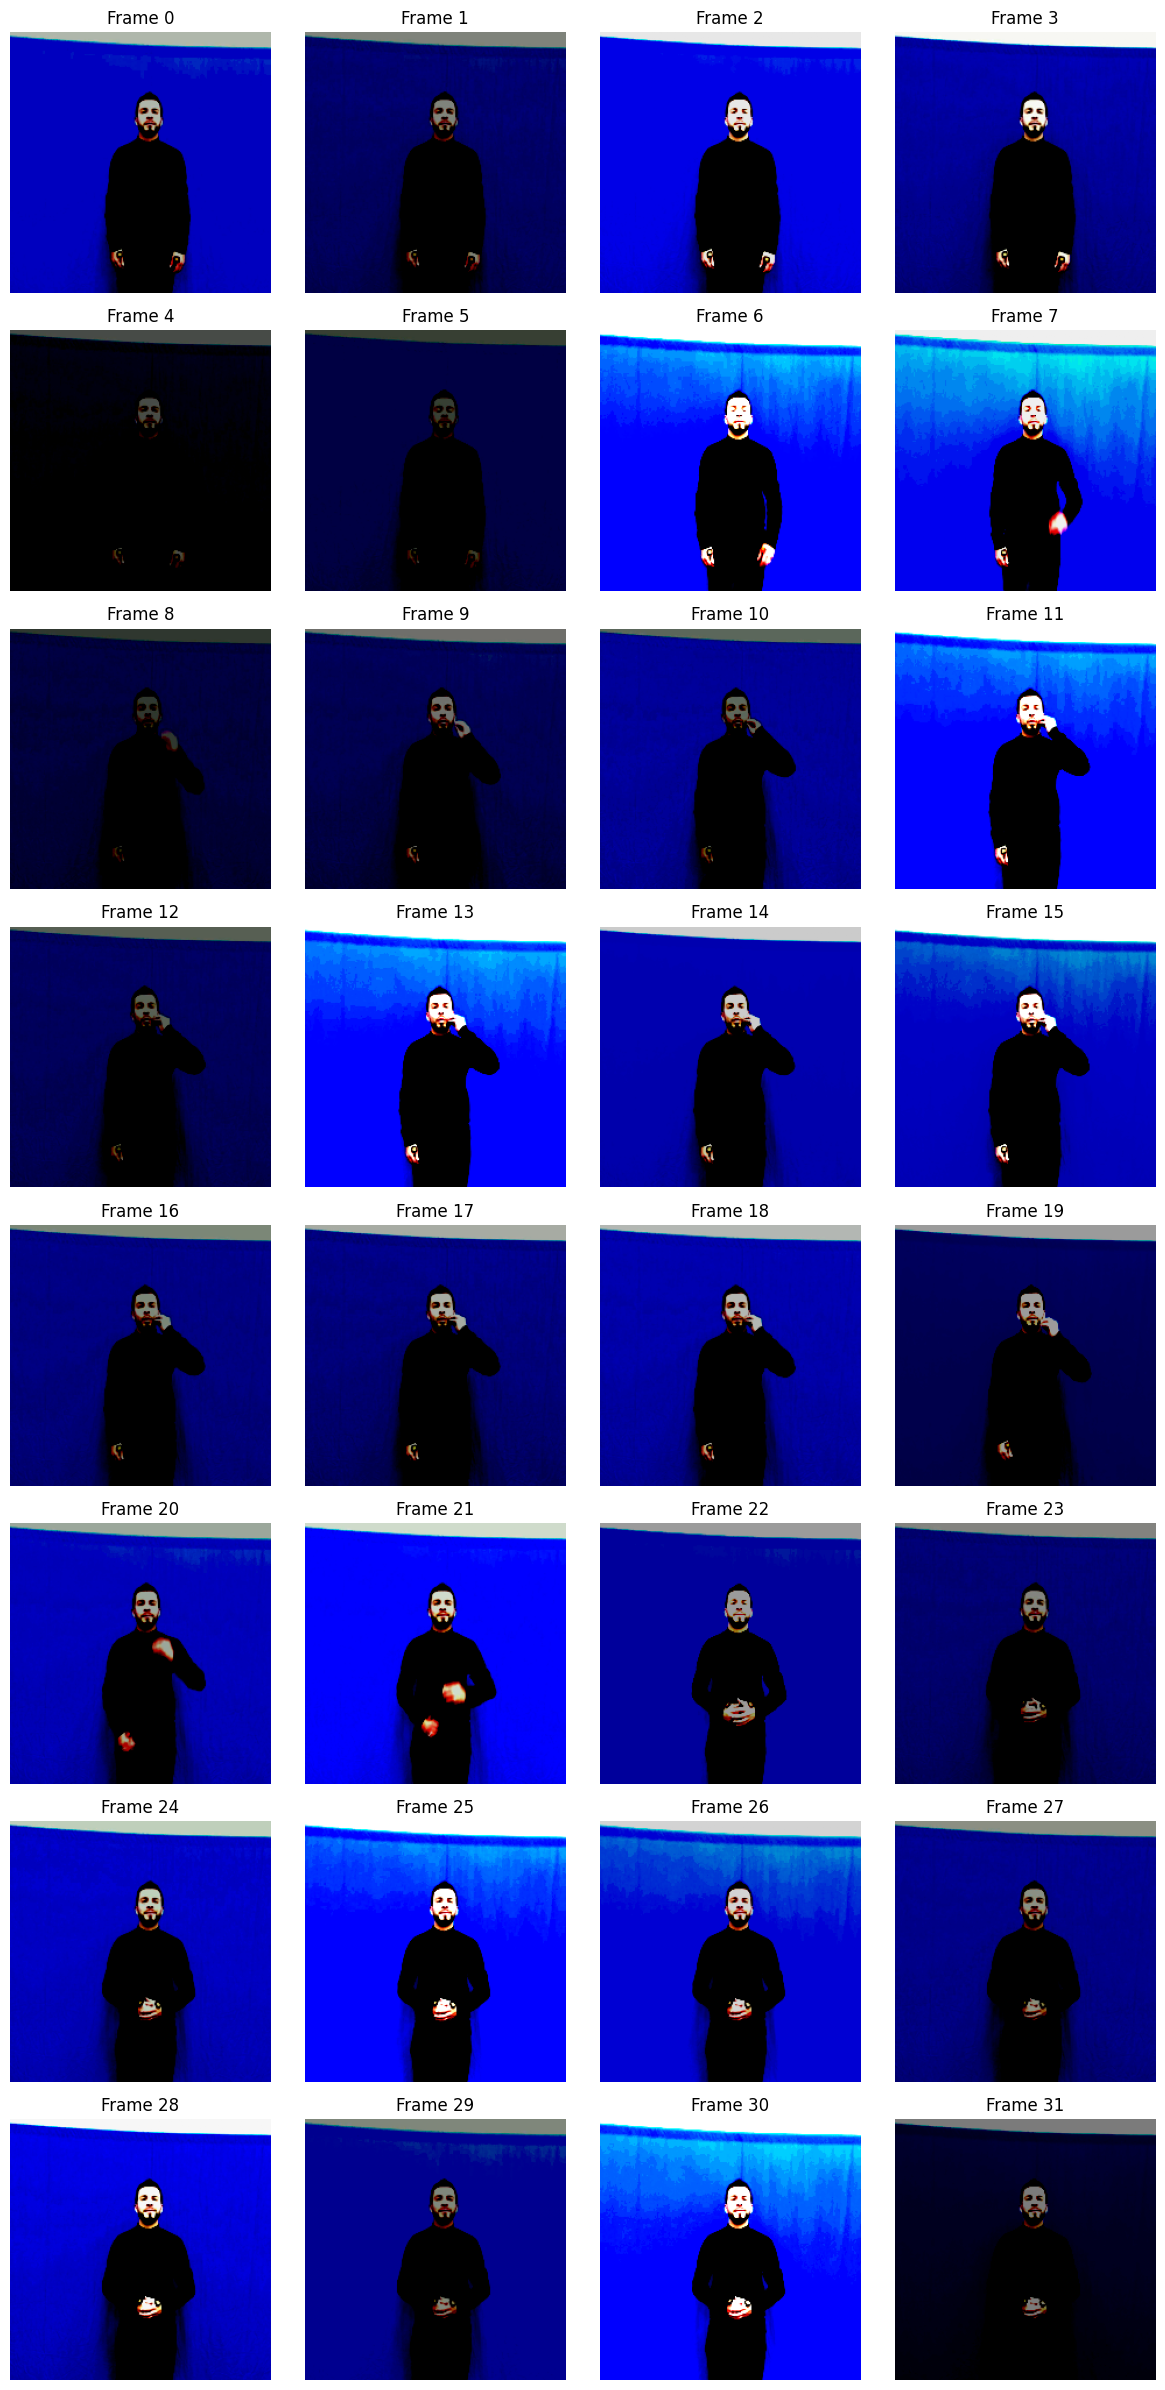

In [7]:
import matplotlib.pyplot as plt

def show_video_frames(pixel_values, n=16, rows=4, cols=4):
    n = min(n, len(pixel_values))
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        frame = pixel_values[i].permute(1, 2, 0).cpu().numpy()
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Frame {i}')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
example = processed_dataset['train'][0]
show_video_frames(example['pixel_values'], n=32, rows=8, cols=4)

## PASO 5: Configurar el Entrenamiento

In [8]:
output_dir = "./results/vivit-LSC-finetuned"
learning_rate = 4.9610155578982295e-05 
batch_size = 4
num_epochs = 24 

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.013320764183634398,         
    
    # Estrategias de Evaluación y Guardado
    eval_strategy="epoch",    # Evaluar al final de cada época
    save_strategy="epoch",          # Guardar al final de cada época
    load_best_model_at_end=True,    # Cargar el mejor modelo al final
    save_total_limit=2,             # Guardar solo los 2 últimos/mejores checkpoints
    metric_for_best_model="f1_weighted",
    greater_is_better=True,         # Mejor si el F1 ponderado es mayor
    # Logging y Otros
    logging_dir=f"{output_dir}/logs",
    logging_steps=10,               # Cada cuántos pasos mostrar logs
    remove_unused_columns=False,    # Importante si tu dataset tiene columnas extra
    fp16=torch.cuda.is_available(), # Usar precisión mixta si hay GPU (acelera y ahorra VRAM)
    # Early stopping
    # Opcional: Para Optuna más adelante
    # report_to="none", # Podrías cambiarlo a 'wandb' o 'tensorboard'
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,             
    args=training_args,                
    train_dataset=processed_dataset["train"], 
    eval_dataset=processed_dataset["validation"], 
    tokenizer=image_processor,         
    compute_metrics=compute_metrics,
    data_collator=data_collator,   
    callbacks=[EarlyStoppingCallback(
            early_stopping_patience=3,        # <-- aquí va la paciencia
            early_stopping_threshold=0.0      # <-- aquí el delta mínimo de mejora
        )]
)

C:\Users\danie\AppData\Local\Temp\ipykernel_8404\3314852651.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## PASO 6: Iniciando Entrenamiento

In [9]:
try:
    # Lanza el proceso de entrenamiento
    train_results = trainer.train()

    print("\n--- Entrenamiento Finalizado ---")

    # Guarda el mejor modelo encontrado durante el entrenamiento
    print("Guardando el mejor modelo...")
    trainer.save_model()

    # Guarda las métricas del entrenamiento
    print("Guardando métricas de entrenamiento...")
    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)

    # Guarda el estado del Trainer (útil para reanudar)
    trainer.save_state()
    print("Métricas y estado del Trainer guardados.")

except Exception as e:
    print(f"\nOcurrió un error durante el entrenamiento: {e}")
    print("Revisa los mensajes de error anteriores.")
    print("Posibles causas: Memoria VRAM/RAM insuficiente (reduce 'batch_size'),")
    print("problemas con los datos, configuración incorrecta o errores de CUDA.")

c:\Users\danie\Documents\TFM\training_models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\Documents\TFM\training_models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\Documents\TFM\training_models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi


--- Entrenamiento Finalizado ---
Guardando el mejor modelo...
Guardando métricas de entrenamiento...
***** train metrics *****
  epoch                    =         14.0
  total_flos               = 5011142135GF
  train_loss               =       0.7499
  train_runtime            =   0:35:05.25
  train_samples_per_second =         1.71
  train_steps_per_second   =        0.433
Métricas y estado del Trainer guardados.


## PASO 7: Testear el modelo

C:\Users\danie\AppData\Local\Temp\ipykernel_8404\4231725299.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  test_trainer = Trainer(


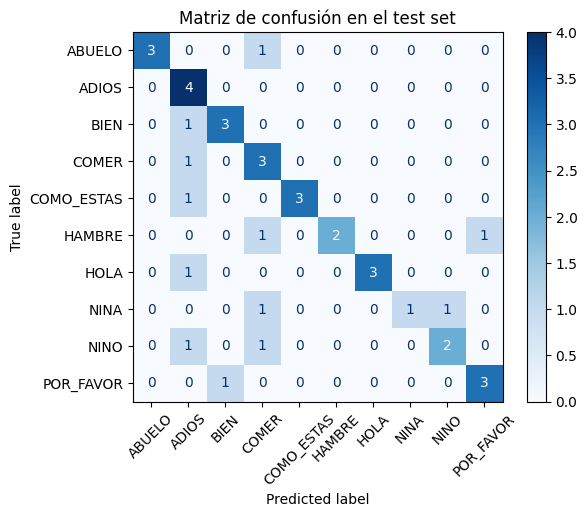

In [10]:
from transformers import VivitForVideoClassification # El modelo que usas (ej: AutoModelForImageClassification)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = VivitForVideoClassification.from_pretrained(r"results\vivit-LSC-finetuned",)

# Prepara el Trainer solo para evaluación
test_trainer = Trainer(
    model=model,    
    args=training_args,  # Puedes reusar los mismos argumentos, ajustando output_dir si quieres
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    eval_dataset=processed_dataset["test"]
)

pred_output = test_trainer.predict(processed_dataset["test"])
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=1)  # Si es clasificación multiclase


cm = confusion_matrix(y_true, y_pred)

class_names = [id2label[i] for i in range(len(id2label))]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión en el test set")
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 (macro y weighted)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision Macro:   {precision_macro:.4f}")
print(f"Precision Weighted:{precision_weighted:.4f}")
print(f"Recall Macro:      {recall_macro:.4f}")
print(f"Recall Weighted:   {recall_weighted:.4f}")
print(f"F1 Macro:          {f1_macro:.4f}")
print(f"F1 Weighted:       {f1_weighted:.4f}")

# Classification report con nombres de clase
target_names = [id2label[i] for i in range(len(id2label))]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

Accuracy: 0.6923
Precision Macro:   0.8040
Precision Weighted:0.7989
Recall Macro:      0.6833
Recall Weighted:   0.6923
F1 Macro:          0.6970
F1 Weighted:       0.7021

Classification Report:
              precision    recall  f1-score   support

      ABUELO       1.00      0.75      0.86         4
       ADIOS       0.44      1.00      0.62         4
        BIEN       0.75      0.75      0.75         4
       COMER       0.43      0.75      0.55         4
  COMO_ESTAS       1.00      0.75      0.86         4
      HAMBRE       1.00      0.50      0.67         4
        HOLA       1.00      0.75      0.86         4
        NINA       1.00      0.33      0.50         3
        NINO       0.67      0.50      0.57         4
   POR_FAVOR       0.75      0.75      0.75         4

    accuracy                           0.69        39
   macro avg       0.80      0.68      0.70        39
weighted avg       0.80      0.69      0.70        39



Patches por frame: 98 -> Grid: 7 x 14


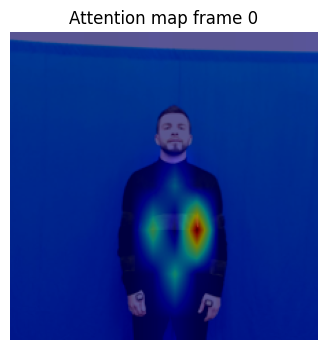

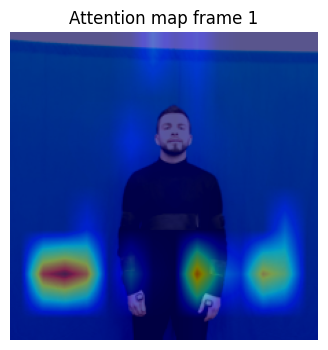

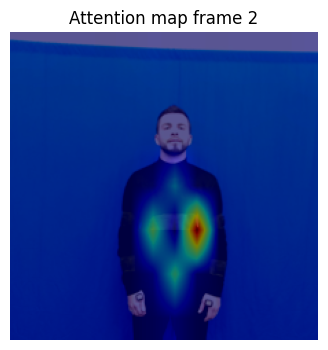

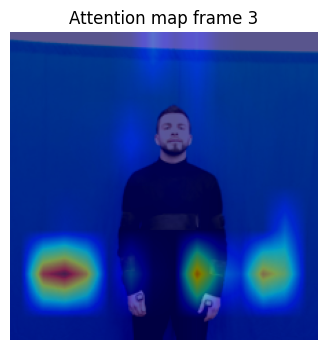

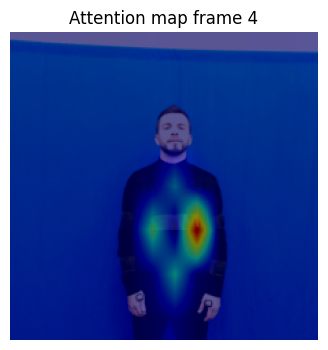

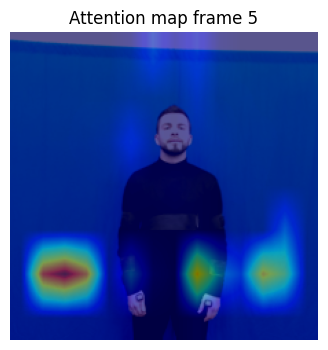

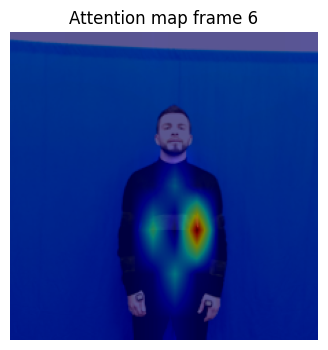

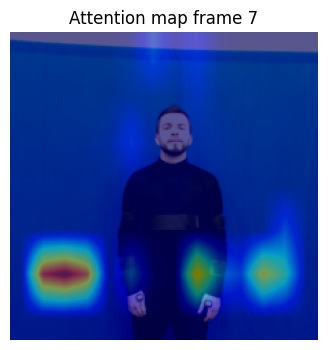

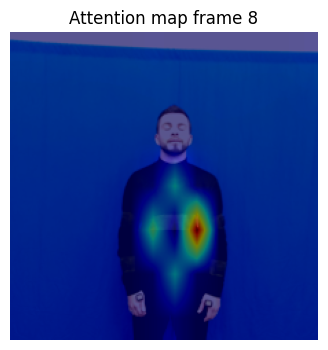

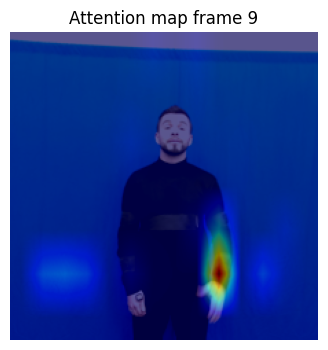

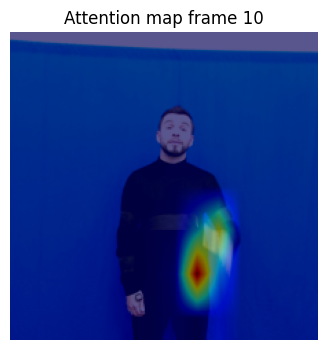

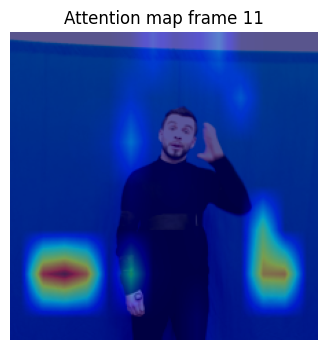

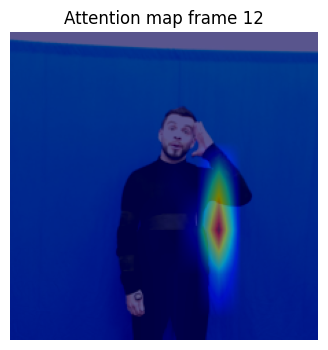

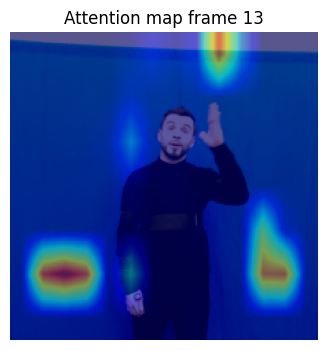

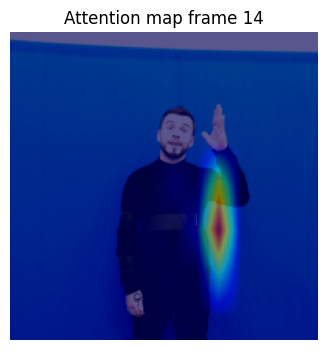

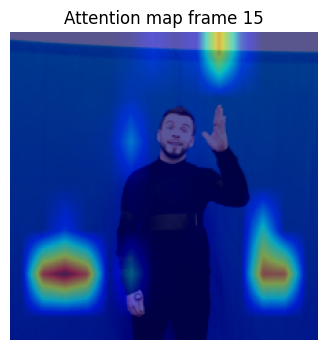

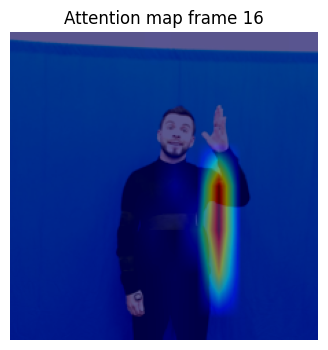

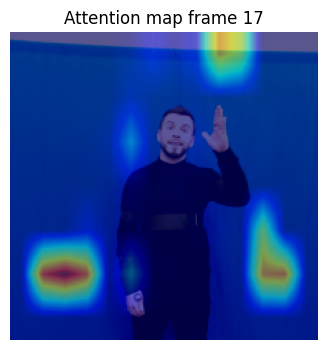

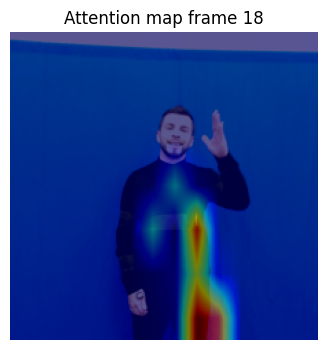

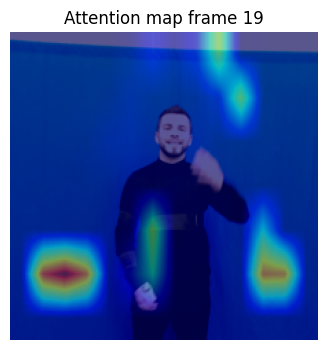

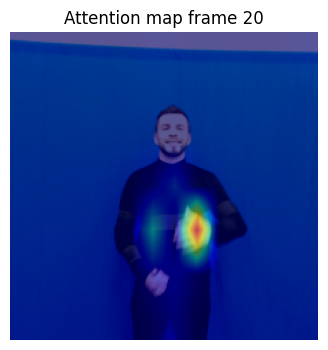

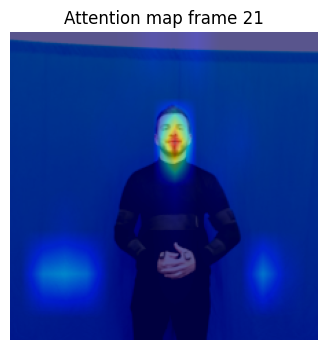

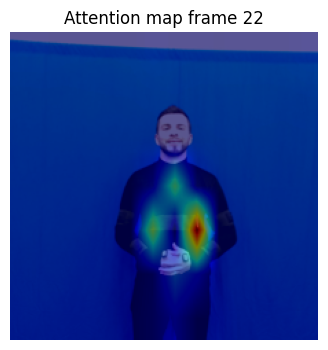

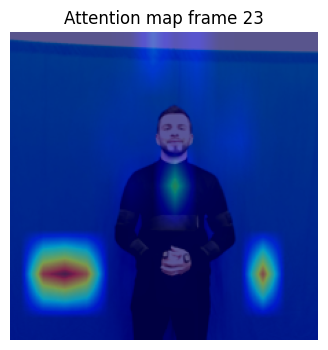

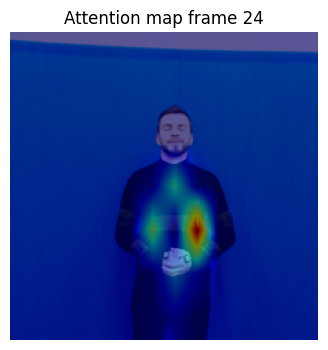

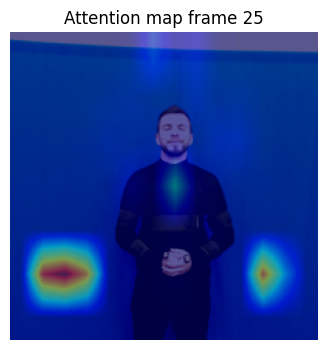

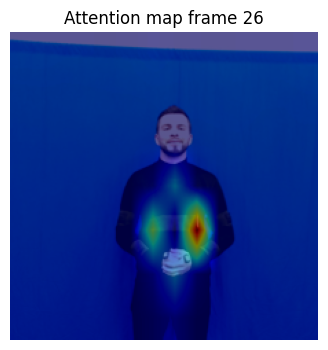

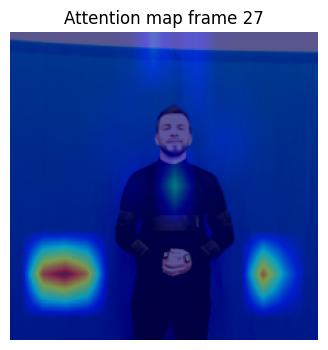

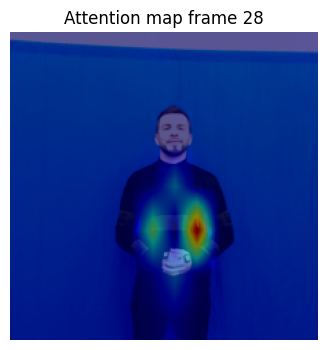

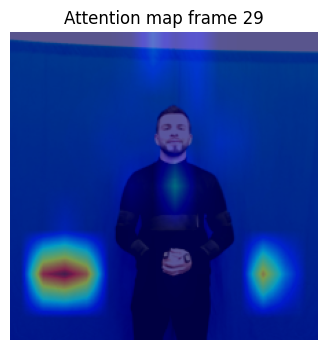

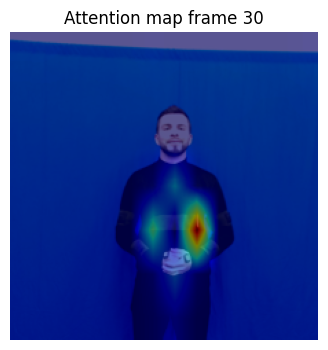

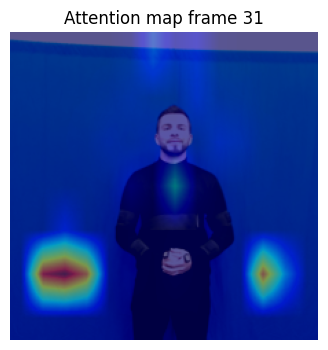

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

video_input = processed_dataset["test"][25]['pixel_values']

# --- PREPARACIÓN DEL INPUT ---
# video_input: tu tensor de video, puede estar en varios formatos (sin batch, batch, canales primero, etc)
# El modelo ViViT espera: (batch, num_frames, 3, H, W)

def prepare_vivit_input(video_input, model_device):
    v = video_input
    # Si falta batch, añade
    if v.ndim == 4:
        v = v.unsqueeze(0)
    # v shape puede ser (batch, 3, num_frames, H, W) o (batch, num_frames, 3, H, W)
    if v.shape[2] == 3 and v.shape[1] != 3:
        # (batch, num_frames, 3, H, W), perfecto
        pass
    elif v.shape[1] == 3:
        # (batch, 3, num_frames, H, W) -> (batch, num_frames, 3, H, W)
        v = v.permute(0, 2, 1, 3, 4)
    else:
        raise ValueError(f"Formato de video_input no reconocido: {v.shape}")
    return v.to(model_device)

video_input = prepare_vivit_input(video_input, model.device)

# --- FORWARD Y ATENCIÓN ---
model.eval()
with torch.no_grad():
    outputs = model(
        pixel_values=video_input,
        output_attentions=True,
        return_dict=True
    )

attentions = outputs.attentions  # Lista de [batch, heads, tokens, tokens]

# Algunos ViViT devuelven una lista por capa, otros un solo tensor.
if isinstance(attentions, (list, tuple)):
    last_attention = attentions[-1][0]  # [heads, tokens, tokens], batch=0
else:
    last_attention = attentions[0]

mean_attention = last_attention.mean(0)  # [tokens, tokens]
cls_attention = mean_attention[0, 1:]    # Atención del token CLS a todos los patches

num_frames = video_input.shape[1]
total_patches = cls_attention.shape[0]
num_patches = total_patches // num_frames

# --- ENCONTRAR LA GRID DE PATCHES ---
def closest_factors(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            return i, n // i
    return 1, n

h_p, w_p = closest_factors(num_patches)
print(f"Patches por frame: {num_patches} -> Grid: {h_p} x {w_p}")

# --- VISUALIZACIÓN ---
for i in range(num_frames):
    attn_frame = cls_attention[i*num_patches:(i+1)*num_patches].reshape(h_p, w_p)
    attn_frame = (attn_frame - attn_frame.min()) / (attn_frame.max() - attn_frame.min() + 1e-8)
    attn_frame = attn_frame.cpu().numpy()

    # Visualiza el frame de entrada, desnormalizado (Imagenet)
    frame = video_input[0, i].cpu().numpy()  # (3, H, W)
    frame = np.transpose(frame, (1, 2, 0))  # (H, W, 3)
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    frame = frame * imagenet_std + imagenet_mean
    frame = np.clip(frame, 0, 1)

    H, W = frame.shape[:2]
    attn_resized = cv2.resize(attn_frame, (W, H))
    attn_colored = plt.cm.jet(attn_resized)[..., :3]
    overlay = 0.5 * frame + 0.5 * attn_colored
    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Attention map frame {i}")
    plt.show()

video_input.shape: torch.Size([1, 32, 3, 224, 224])
Patches grid: 14x14 = 196 par frame, num_frames: 32
cls_attention.shape: torch.Size([3136])
Frames completos para visualizar: 16 (de 32), cada uno con 196 patches (14x14)


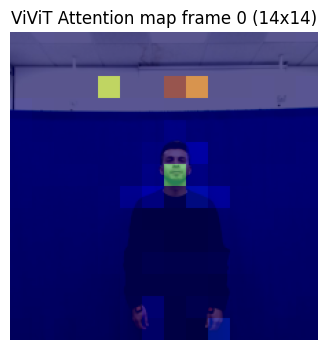

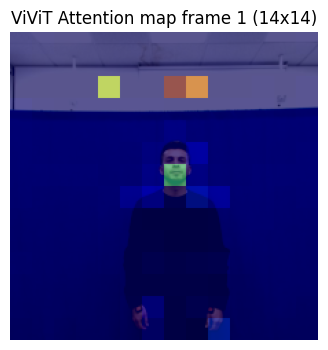

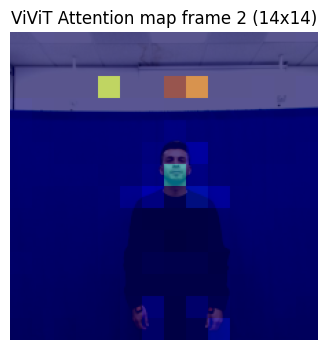

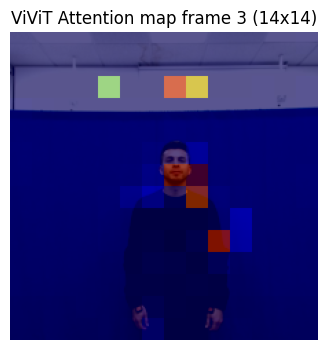

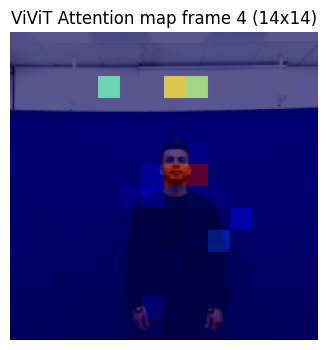

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# --- CONFIGURACIÓN ---
idx = 0  # Cambia este índice para elegir el video a visualizar
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# --- PREPROCESADO ---
sample = processed_dataset["test"][idx]
frames = sample["pixel_values"]  # Esperado: (num_frames, 3, 224, 224)
video_input = frames.unsqueeze(0).to(model.device)  # (1, num_frames, 3, 224, 224)

print("video_input.shape:", video_input.shape)

# --- PATCHES POR FRAME ---
patch_size = getattr(model.config, "patch_size", 16)
H, W = video_input.shape[-2], video_input.shape[-1]
h_p, w_p = H // patch_size, W // patch_size
num_patches = h_p * w_p
num_frames = video_input.shape[1]
print(f"Patches grid: {h_p}x{w_p} = {num_patches} par frame, num_frames: {num_frames}")

# --- INFERENCIA Y ATENCIÓN ---
model.eval()
with torch.no_grad():
    outputs = model(
        pixel_values=video_input,
        output_attentions=True,
        return_dict=True
    )

attentions = outputs.attentions  # [num_layers][batch, heads, tokens, tokens]
last_attention = attentions[-1][0]  # [heads, tokens, tokens]
mean_attention = last_attention.mean(0)
cls_attention = mean_attention[0, 1:]

print("cls_attention.shape:", cls_attention.shape)  # Total patches

# --- CHEQUEO Y AJUSTE DE VISUALIZACIÓN ---
total_patches = cls_attention.shape[0]
max_valid_frames = total_patches // num_patches

print(f"Frames completos para visualizar: {max_valid_frames} (de {num_frames}), cada uno con {num_patches} patches ({h_p}x{w_p})")
if total_patches % num_patches != 0:
    print(f"Atención: Hay {total_patches % num_patches} patches sobrantes (incompletos para un frame). No se visualizarán.")

# --- VISUALIZACIÓN ---
for i in range(min(5, max_valid_frames)):
    attn_patch = cls_attention[i*num_patches:(i+1)*num_patches]
    if attn_patch.numel() != h_p * w_p:
        print(f"Frame {i}: {attn_patch.numel()} patches, esperado {h_p*w_p}, saltando.")
        continue
    attn_frame = attn_patch.reshape(h_p, w_p)
    attn_frame = (attn_frame - attn_frame.min()) / (attn_frame.max() - attn_frame.min() + 1e-8)
    attn_frame = attn_frame.cpu().numpy()

    frame = video_input[0, i].cpu().numpy()
    frame = np.transpose(frame, (1, 2, 0))
    frame = frame * np.array(imagenet_std) + np.array(imagenet_mean)
    frame = np.clip(frame, 0, 1)

    H_img, W_img = frame.shape[:2]
    attn_resized = cv2.resize(attn_frame, (W_img, H_img), interpolation=cv2.INTER_NEAREST)
    attn_colored = plt.cm.jet(attn_resized)[..., :3]
    overlay = 0.5 * frame + 0.5 * attn_colored
    plt.figure(figsize=(4, 4))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"ViViT Attention map frame {i} ({h_p}x{w_p})")
    plt.show()